In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os


import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import re

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils

import matplotlib.pyplot as plt

In [2]:
from keras_frcnn.simple_parser import get_data

In [3]:
#train_path='annotationAlt.txt'
train_path = 'annotationAlt_subset_20im.txt'
parser='simple'
num_rois=4
network='resnet50'
horizontal_flips=False
vertical_flips=False
rot_90=False
im_size=300
config_filename='configSubmission.pickle'
output_weight_path='./Models/model_frcnn_resnet_annotationCar_Submission.hdf5'
#input_weight_path='model/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
input_weight_path='model/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
#input_weight_path='model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
record_path = './Models/record_submission.csv'

In [4]:
C = config.Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.im_size = im_size

C.model_path = output_weight_path

C.num_rois = int(num_rois)

from keras_frcnn import resnet as nn
#from keras_frcnn import vgg as nn
C.network = network

C.base_net_weights = input_weight_path

model_path_regex = re.match("^(.+)(\.hdf5)$", C.model_path)
if model_path_regex.group(2) != '.hdf5':
	print('Output weights must have .hdf5 filetype')
	exit(1)

C.record_path=record_path

###### Parser the data from annotation file

In [5]:
#train_imgs, classes_count, class_mapping = get_data(train_path)

#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files

Spend 0.55 mins to load the data


In [6]:

if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping


In [7]:

inv_map = {v: k for k, v in class_mapping.items()}

print('Training images per class:')
pprint.pprint(classes_count)
print(f'Num classes (including bg) = {len(classes_count)}')


Training images per class:
{'Car': 3920, 'bg': 0}
Num classes (including bg) = 2


In [8]:
config_output_filename = config_filename

In [9]:
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C,config_f)
    print(f'Config has been written to {config_output_filename}, and can be loaded when testing to ensure correct results')


Config has been written to configSubmission.pickle, and can be loaded when testing to ensure correct results


In [10]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

num_imgs = len(train_imgs)

In [11]:
print(f'Num train samples {len(train_imgs)}')

Num train samples 3920


In [12]:
data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, nn.get_img_output_length, K.image_data_format(), mode='train')
#data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, nn.get_img_output_length,K.common.image_dim_ordering(), mode='val')


In [13]:
#X, Y, image_data = next(data_gen_train)
#X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=465 width=619
Resized image:  height=300 width=399 C.im_size=300
Feature map size: height=19 width=25 C.rpn_stride=16
(1, 300, 399, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 19, 25, 18)
Shape of y_rpn_regr (1, 19, 25, 72)
{'filepath': 'data\\Car Images-20210501T094840Z-001\\Car Images\\Train Images\\Chrysler 300 SRT-8 2010\\01057.jpg', 'width': 619, 'height': 465, 'bboxes': [{'class': 'Car', 'x1': 6, 'x2': 588, 'y1': 178, 'y2': 386}], 'imageset': 'test'}
Number of positive anchors for this image: 6
(array([ 4,  7,  8, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13,
       13], dtype=int64), array([19, 14,  5, 11, 11, 12, 12, 13, 11, 11, 12, 12, 11, 11, 12, 12,  6,
        7], dtype=int64), array([ 0,  1,  0,  5, 14,  5, 14,  0,  5, 14,  5, 14,  5, 14,  5, 14,  2,
        2], dtype=int64))
(array([10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12,
       12, 12, 12, 12, 12, 12, 12], dtype=int64), array([11, 11, 11, 

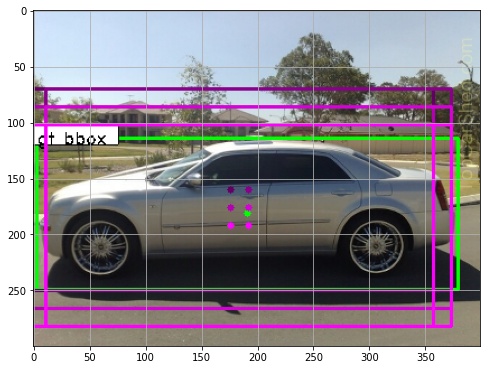

In [14]:
#X, Y, image_data = next(data_gen_train)
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)


print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()



In [15]:

if K.image_data_format() == 'channels_first':
    input_shape_img = (3, None, None)
else:
    input_shape_img = (None, None, 3)
    
    
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)


# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

loading weights from model/resnet50_weights_tf_dim_ordering_tf_kernels.h5


In [16]:

optimizer = Adam(learning_rate=1e-4)
optimizer_classifier = Adam(learning_rate=1e-4)
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={f'dense_class_{len(classes_count)}': 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')
#model_all.compile(optimizer=optimizer, loss='mae')


In [17]:
196*10

1960

In [18]:
class_mapping_inv = {v: k for k, v in class_mapping.items()}


# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)


epoch_length = 4000
#keep epoch lenght considering number of images you have we have a suubset of 392 as of now, plan to increase to 8k
num_epochs = 2
iter_num = 0



total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [19]:
print('Starting training')


Starting training


In [20]:
vis = True
start_time = time.time()

for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1
    
    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                print(f'Average number of overlapping bounding boxes from RPN = {mean_overlapping_bboxes} for {epoch_length} previous iterations')
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            X, Y, img_data, debug_img, debug_num_pos  = next(data_gen_train)

            loss_rpn = model_rpn.train_on_batch(X, Y)

            P_rpn = model_rpn.predict_on_batch(X)

            R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []
            
            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            progbar.update(iter_num+1, [('rpn_cls', losses[iter_num, 0]), ('rpn_regr', losses[iter_num, 1]),
                                      ('detector_cls', losses[iter_num, 2]), ('detector_regr', losses[iter_num, 3])])

            iter_num += 1
            
            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print(f'Mean number of bounding boxes from RPN overlapping ground truth boxes: {mean_overlapping_bboxes}')
                    print(f'Classifier accuracy for bounding boxes from RPN: {class_acc}')
                    print(f'Loss RPN classifier: {loss_rpn_cls}')
                    print(f'Loss RPN regression: {loss_rpn_regr}')
                    print(f'Loss Detector classifier: {loss_class_cls}')
                    print(f'Loss Detector regression: {loss_class_regr}')
                    print(f'Elapsed time: {time.time() - start_time}')
                    elapsed_time = (time.time()-start_time)/60
                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()
                
                print(f'Total loss in epoch {curr_loss} & best loss is {best_loss}')

                if curr_loss < best_loss:
                    if C.verbose:
                        print(f'Total loss decreased from {best_loss} to {curr_loss}, saving weights')
                    best_loss = curr_loss
                    #model_all.save_weights(model_path_regex.group(1) + "_" + '{:04d}'.format(epoch_num) + model_path_regex.group(2))
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                       'class_acc':round(class_acc, 3), 
                       'loss_rpn_cls':round(loss_rpn_cls, 3), 
                       'loss_rpn_regr':round(loss_rpn_regr, 3), 
                       'loss_class_cls':round(loss_class_cls, 3), 
                       'loss_class_regr':round(loss_class_regr, 3), 
                       'curr_loss':round(curr_loss, 3), 
                       'elapsed_time':round(elapsed_time, 3), 
                        'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)
                
                
                break

        except Exception as e:
            print(f'Exception: {e}')
            continue

print('Training complete, exiting.')
#print('Spend %0.2f mins to run' % ((time.time()-start_time)/60) )

Epoch 1/2
4000/4000 [==============================] - 12091s 3s/step - rpn_cls: 0.3216 - rpn_regr: 0.1176 - detector_cls: 0.2987 - detector_regr: 0.2862
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.063
Classifier accuracy for bounding boxes from RPN: 0.8738125
Loss RPN classifier: 0.3215938416706923
Loss RPN regression: 0.11759546489920467
Loss Detector classifier: 0.2986673763313447
Loss Detector regression: 0.2862222410030663
Elapsed time: 12090.611158132553
Total loss in epoch 1.024078923904308 & best loss is inf
Total loss decreased from inf to 1.024078923904308, saving weights
Epoch 2/2
Average number of overlapping bounding boxes from RPN = 12.063 for 4000 previous iterations
4000/4000 [==============================] - 14738s 4s/step - rpn_cls: 0.2951 - rpn_regr: 0.1066 - detector_cls: 0.2397 - detector_regr: 0.1751
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.661
Classifier accuracy for bounding boxes from RPN: 0.903437

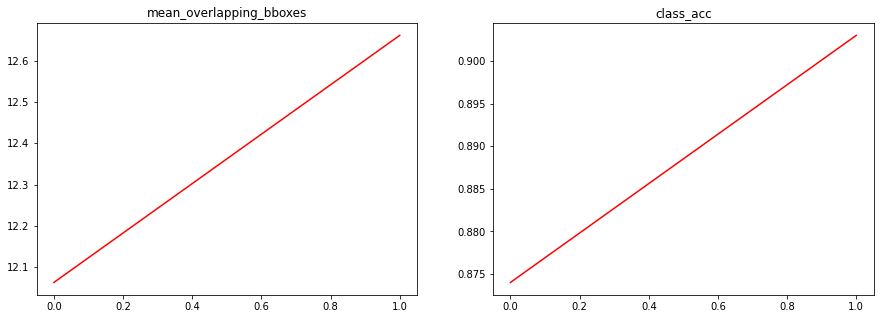

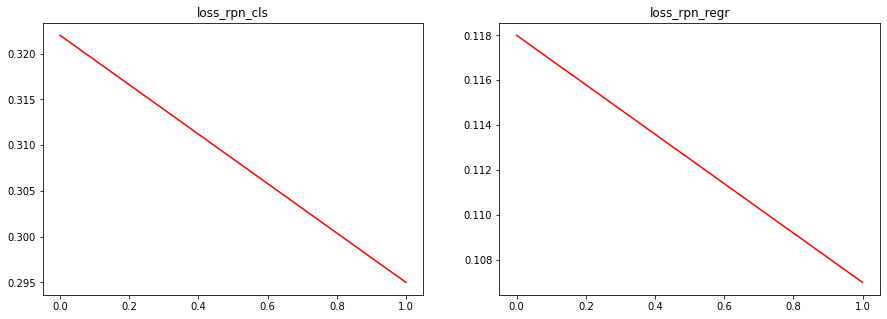

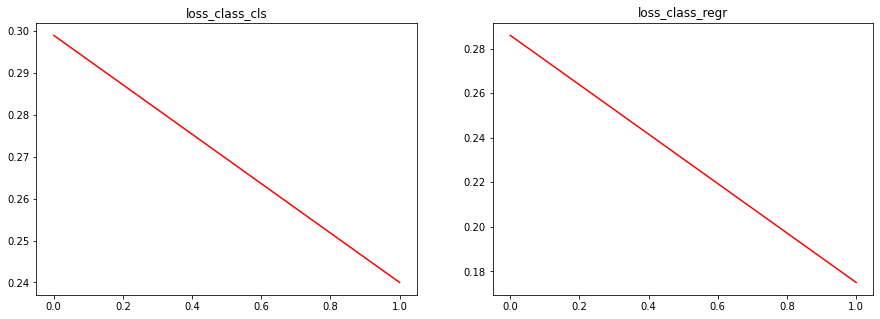

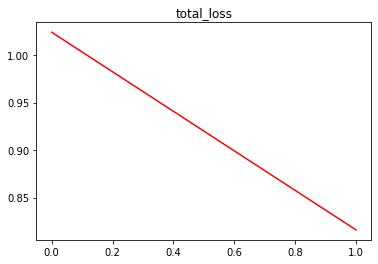

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
# plt.title('total_loss')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
# plt.title('elapsed_time')
# plt.show()

# plt.title('loss')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'b')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'g')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'c')
# # plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'm')
# plt.show()